In [1]:
# back to project root
%cd /mnt/c/research

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import sys
from glob import glob
import yaml

sys.path.append('src')
from group.passing.dataset import make_all_data
from utility import transform, json_handler
from utility.logger import logger
from utility.functions import cos_similarity, gauss
from utility.activity_loader import load_individuals
from tools.train_passing import init_model

/mnt/c/research


/mnt/c/research/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Indivisual Activity をロード

In [2]:
cfg_path = "config/passing/pass_train.yaml"
with open(cfg_path, "r") as f:
    cfg = yaml.safe_load(f)

In [3]:
data_dirs_all = {}
for room_num, date_items in cfg["dataset"]["setting"].items():
    for surgery_num in date_items.keys():
        dirs = sorted(glob(os.path.join("data", room_num, surgery_num, "passing", "*")))
        data_dirs_all[f"{room_num}_{surgery_num}"] = dirs

logger.info(f"=> loading individuals from {data_dirs_all}")
inds = {}
for key_prefix, dirs in data_dirs_all.items():
    for model_path in dirs:
        num = model_path.split("/")[-1]
        json_path = os.path.join(model_path, ".json", "individual.json")
        tmp_inds, _ = load_individuals(json_path, cfg["individual"])
        for pid, ind in tmp_inds.items():
            inds[f"{key_prefix}_{num}_{pid}"] = ind

2022-05-14 12:44:26 [INFO]: => loading individuals from {'02_20210903': ['data/02/20210903/passing/01', 'data/02/20210903/passing/02', 'data/02/20210903/passing/03', 'data/02/20210903/passing/04', 'data/02/20210903/passing/05', 'data/02/20210903/passing/06', 'data/02/20210903/passing/07', 'data/02/20210903/passing/08', 'data/02/20210903/passing/09', 'data/02/20210903/passing/10', 'data/02/20210903/passing/11', 'data/02/20210903/passing/12', 'data/02/20210903/passing/13', 'data/02/20210903/passing/14', 'data/02/20210903/passing/15', 'data/02/20210903/passing/16', 'data/02/20210903/passing/17', 'data/02/20210903/passing/18', 'data/02/20210903/passing/19', 'data/02/20210903/passing/20', 'data/02/20210903/passing/21', 'data/02/20210903/passing/22', 'data/02/20210903/passing/23'], '08_20210915': ['data/08/20210915/passing/01', 'data/08/20210915/passing/02', 'data/08/20210915/passing/03', 'data/08/20210915/passing/04', 'data/08/20210915/passing/05', 'data/08/20210915/passing/06', 'data/08/20

# 特徴量抽出とデータ生成

In [4]:
# create model
model_cfg_path = cfg["group"]["indicator"]["passing"]["cfg_path"]
grp_defs = cfg["group"]["indicator"]["passing"]["default"]
detector = init_model(model_cfg_path, grp_defs, model=None)

x_dict, y_dict = make_all_data(detector, inds, cfg["dataset"]["setting"], logger)

/mnt/c/research/.venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
2022-05-14 12:44:40 [INFO]: => createing time series 02_20210903
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.24it/s]
2022-05-14 12:44:44 [INFO]: => createing time series 08_20210915
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:03<00:00, 10.45it/s]
2022-05-14 12:44:48 [INFO]: => createing time series 09_20210706
100%|█████████████████████████████████████████████████

In [5]:
for room_num, date_items in cfg["dataset"]["setting"].items():
    print(room_num)
    
    y_lst_all = []
    for key, y_lst in y_dict.items():
        if key[:2] == room_num:
            y_lst_all += y_lst

    len_pass = len([i for i in y_lst_all if i == 1])
    len_not_pass = len([i for i in y_lst_all if i == 0])

    print(f'all length:{len(y_lst_all)}')
    print(f'passing: {len_pass}')
    print(f'not passing: {len_not_pass}')
    
print('total')
y_lst_all = []
for key, y_lst in y_dict.items():
    y_lst_all += y_lst

len_pass = len([i for i in y_lst_all if i == 1])
len_not_pass = len([i for i in y_lst_all if i == 0])

print(f'all length:{len(y_lst_all)}')
print(f'passing: {len_pass}')
print(f'not passing: {len_not_pass}')

02
all length:151627
passing: 587
not passing: 151040
08
all length:137814
passing: 1034
not passing: 136780
09
all length:87671
passing: 366
not passing: 87305
total
all length:377112
passing: 1987
not passing: 375125


In [6]:
# setting random seed
SEED = 64
np.random.seed(SEED)

train_len = int(len(x_dict) * 0.7)

random_keys = np.random.choice(
    list(x_dict.keys()),
    size=len(x_dict),
    replace=False
)

train_keys = random_keys[:train_len]
test_keys = random_keys[train_len:]

x_train_dict = {key: x_dict[key] for key in train_keys}
y_train_dict = {key: y_dict[key] for key in train_keys}

x_test_dict = {key: x_dict[key] for key in test_keys}
y_test_dict = {key: y_dict[key] for key in test_keys}

In [7]:
train_1 = {key: y_dict[key] for key in train_keys if 1 in y_dict[key]}
print(len(train_1))
train_0 = {key: y_dict[key] for key in train_keys if 0 in y_dict[key]}
print(len(train_0))

train_1_frame = 0
train_0_frame = 0
for data in y_train_dict.values():
    train_1_frame += len([val for val in data if val == 1])
    train_0_frame += len([val for val in data if val == 0])
    
print(train_1_frame)
print(train_0_frame)

56
3755
1286
261304


In [8]:
test_1 = {key: y_dict[key] for key in test_keys if 1 in y_dict[key]}
print(len(test_1))
test_0 = {key: y_dict[key] for key in test_keys if 0 in y_dict[key]}
print(len(test_0))

test_1_frame = 0
test_0_frame = 0
for data in y_test_dict.values():
    test_1_frame += len([val for val in data if val == 1])
    test_0_frame += len([val for val in data if val == 0])
print(test_1_frame)
print(test_0_frame)

20
1610
701
113821


# 分布

In [9]:
def extract_feature(x_dict, y_dict, col_num, is_pass):
    hist = {}
    for room_num, date_items in cfg["dataset"]["setting"].items():
        for surgery_num in date_items.keys():
            hist_room = []
            for key, x_lst, y_lst in zip(x_dict.keys(), x_dict.values(), y_dict.values()):
                x_lst = np.array(x_lst)
                if room_num in key and is_pass in y_lst:
                    hist_room += x_lst.T[col_num].tolist()
            hist[room_num] = hist_room
        
    return hist

## 受け渡し動作中の距離の分布を見る

In [10]:
hist_dist_1 = extract_feature(
    x_dict,
    y_dict,
    0,
    1
)

0.7988022519470166
0.11560810204714474


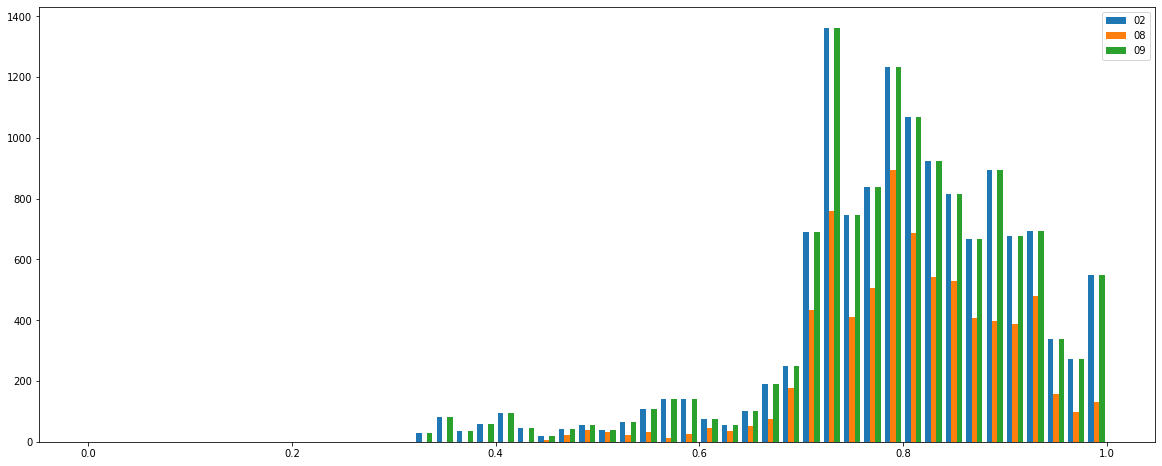

In [11]:
data = []
for vals in hist_dist_1.values():
    for val in vals:
        if val < 2000:
            data.append(val)
print(np.mean(data))
print(np.std(data))

plt.figure(figsize=(20, 8))
plt.hist(hist_dist_1.values(), bins=50, range=(0, 1), label=list(hist_dist_1.keys()))
# plt.vlines(np.mean(data), 0, 1000)
plt.legend()

In [12]:
hist_dist_0 = extract_feature(
    x_dict,
    y_dict,
    0,
    0
)

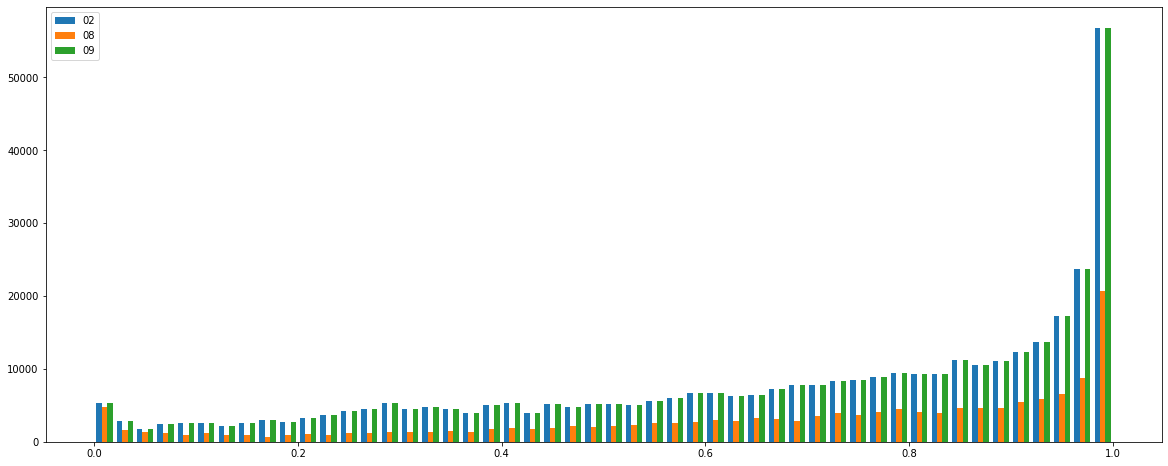

In [13]:
plt.figure(figsize=(20, 8))
plt.hist(hist_dist_0.values(), bins=50, range=(0, 1), label=list(hist_dist_0.keys()))
plt.legend()

## 受け渡し動作中の体の向きの分布を見る

In [14]:
hist_body_1 = extract_feature(
    x_dict,
    y_dict,
    1,
    1
)

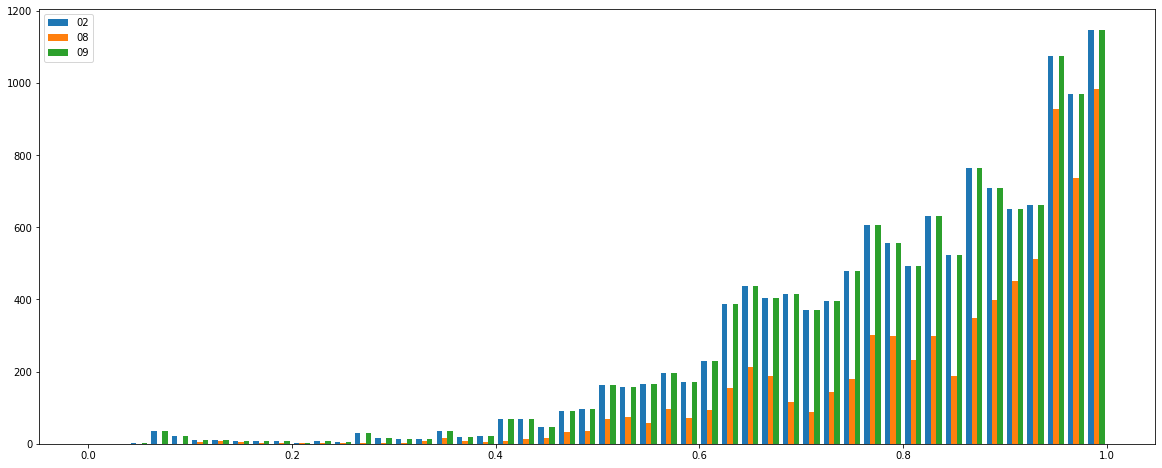

In [15]:
plt.figure(figsize=(20, 8))
plt.hist(hist_body_1.values(), bins=50, range=(0, 1), label=list(hist_body_1.keys()))
plt.legend()

In [16]:
hist_body_0 = extract_feature(
    x_dict,
    y_dict,
    1,
    0
)

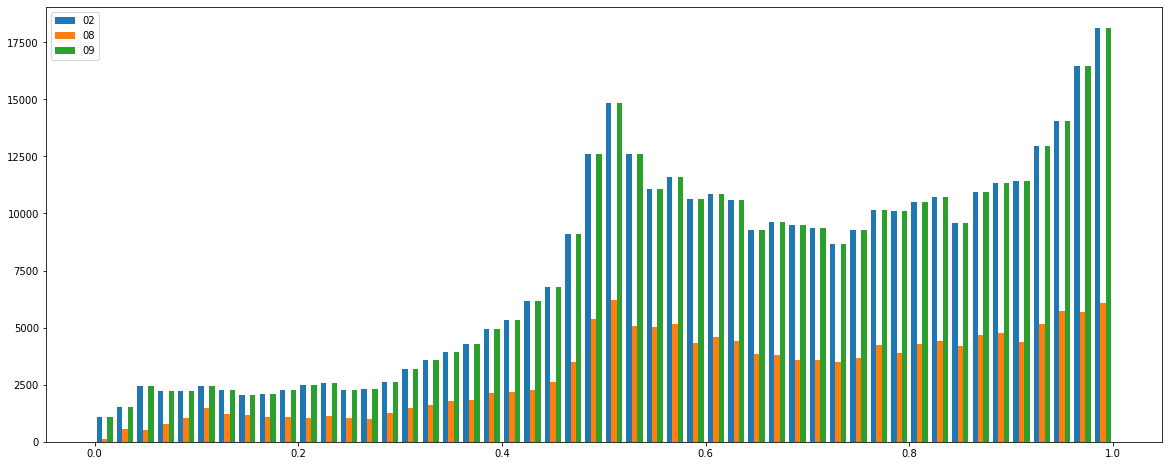

In [17]:
plt.figure(figsize=(20, 8))
plt.hist(hist_body_0.values(), bins=50, range=(0, 1), label=list(hist_body_0.keys()))
plt.legend()

## 受け渡し動作中の腕の上げ下げの分布を見る

In [18]:
hist_arm_1 = extract_feature(
    x_dict,
    y_dict,
    2,
    1
)

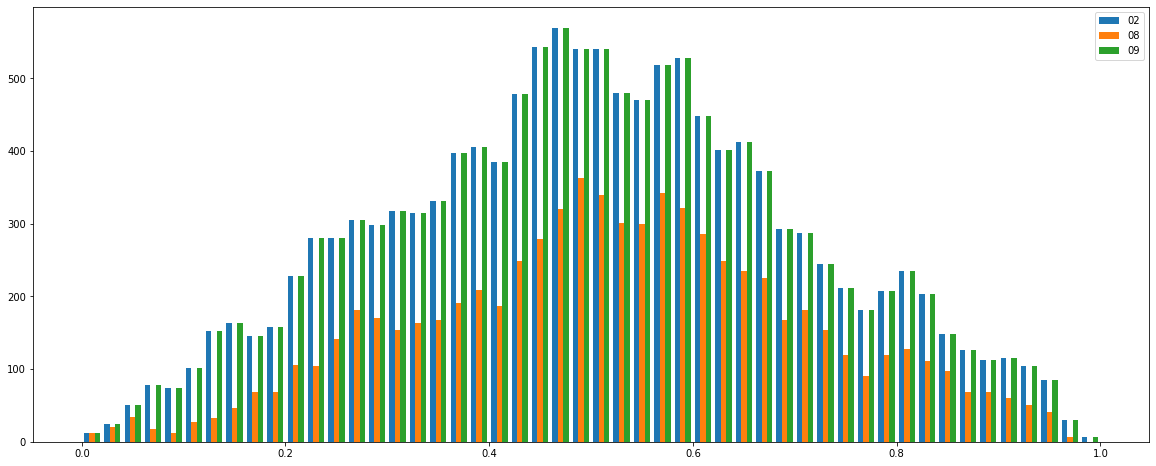

In [19]:
plt.figure(figsize=(20, 8))
plt.hist(hist_arm_1.values(), bins=50, range=(0, 1), label=list(hist_arm_1.keys()))
plt.legend()

In [20]:
hist_arm_0 = extract_feature(
    x_dict,
    y_dict,
    2,
    0
)

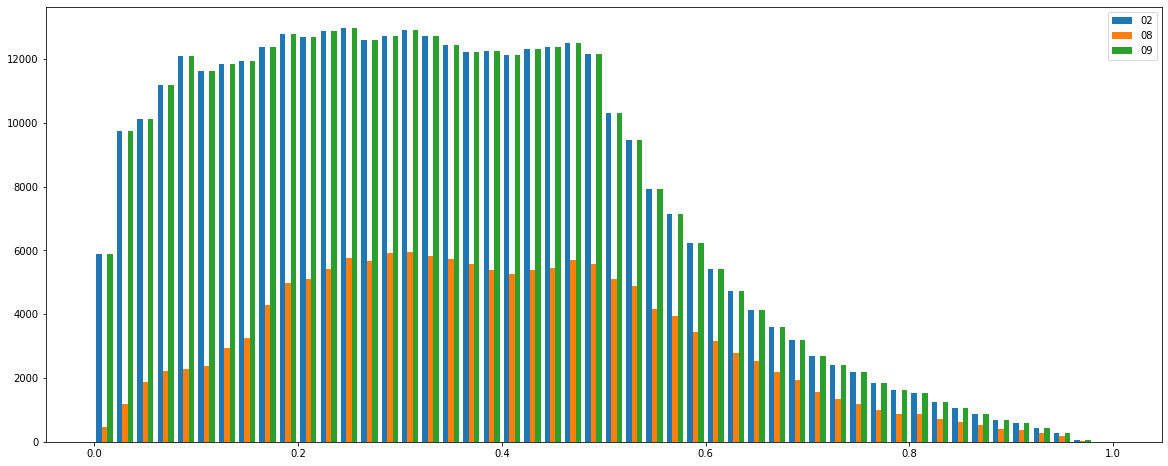

In [21]:
plt.figure(figsize=(20, 8))
plt.hist(hist_arm_0.values(), bins=50, range=(0, 1), label=list(hist_arm_0.keys()))
plt.legend()

## 受け渡し動作中の手首の距離の分布を見る

In [22]:
hist_wrist_1 = extract_feature(
    x_dict,
    y_dict,
    3,
    1
)

0.47443669446135306
0.3576361657004896


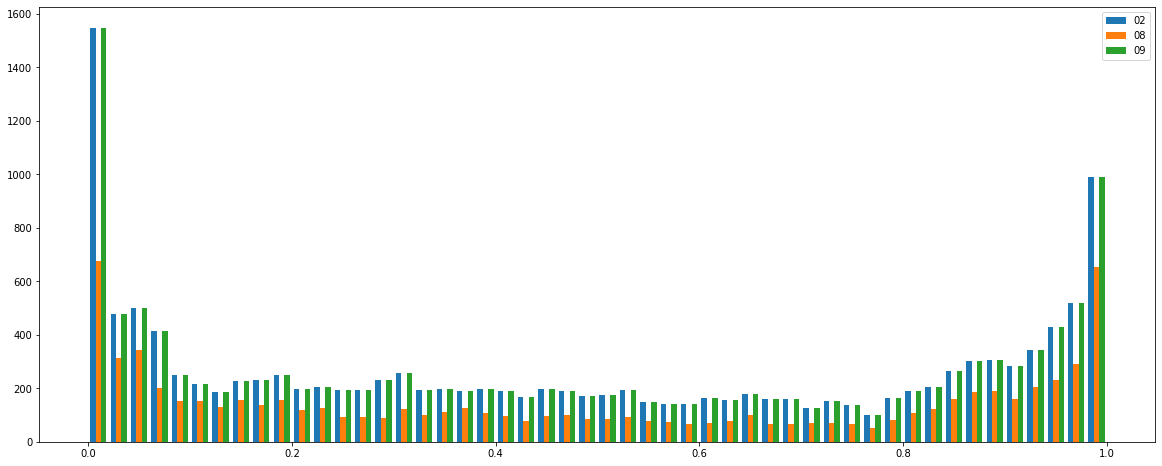

In [23]:
data = []
for vals in hist_wrist_1.values():
    for val in vals:
        if val < 2000:
            data.append(val)
print(np.mean(data))
print(np.std(data))

plt.figure(figsize=(20, 8))
plt.hist(hist_wrist_1.values(), bins=50, range=(0, 1), label=list(hist_wrist_1.keys()))
plt.legend()

In [24]:
hist_wrist_0 = extract_feature(
    x_dict,
    y_dict,
    3,
    0
)

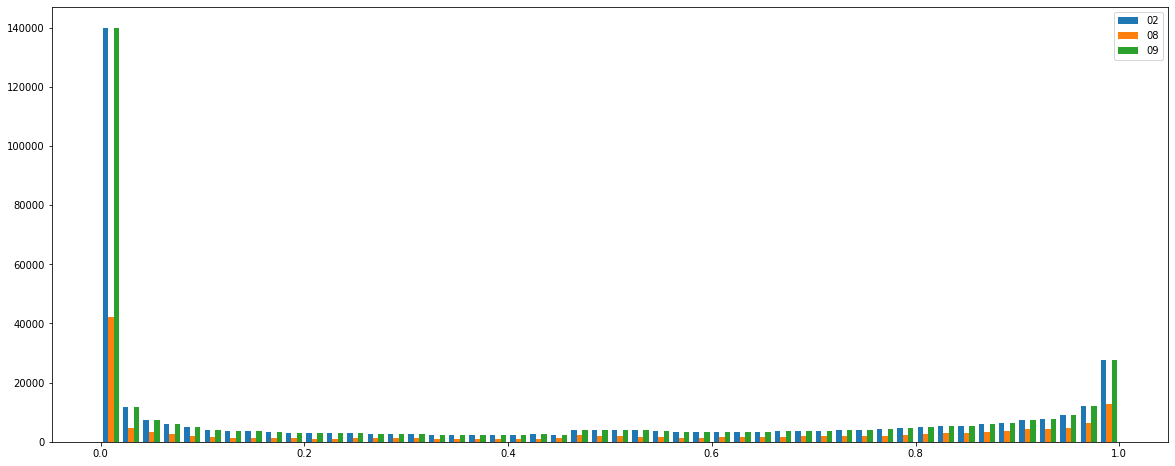

In [25]:
plt.figure(figsize=(20, 8))
plt.hist(hist_wrist_0.values(), bins=50, range=(0, 1), label=list(hist_wrist_0.keys()))
plt.legend()

# 時系列でプロット

02_20210903_02_10_11


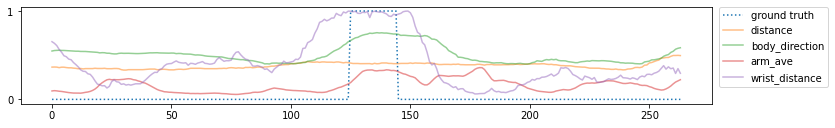

02_20210903_02_10_13


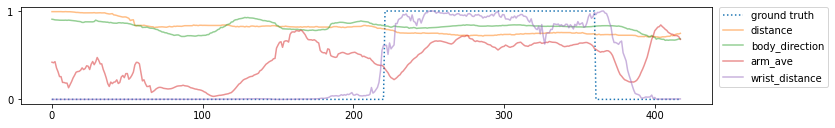

02_20210903_03_27_31


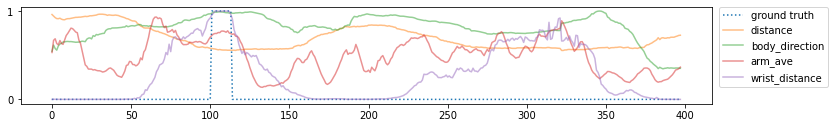

02_20210903_04_44_43


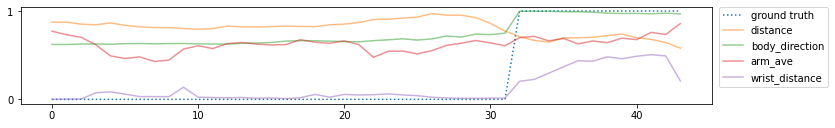

02_20210903_05_48_52


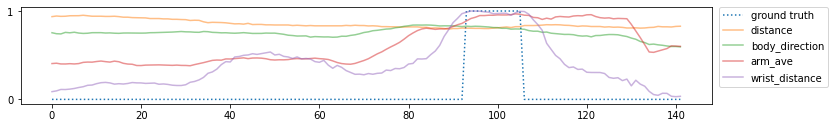

02_20210903_06_63_66


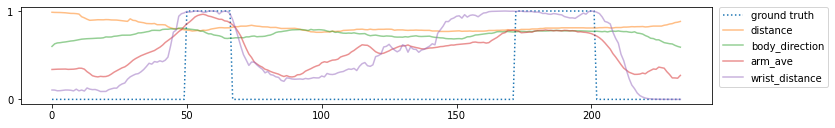

02_20210903_07_76_79


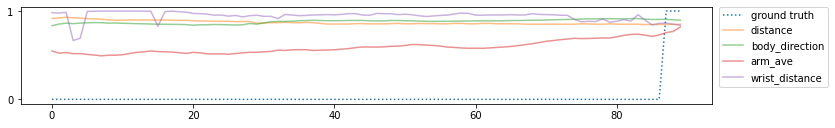

02_20210903_08_86_90


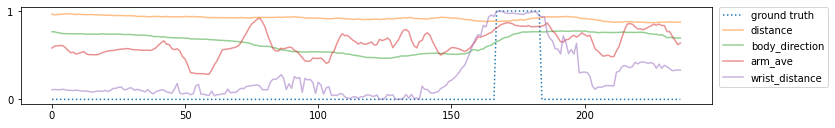

02_20210903_09_102_109


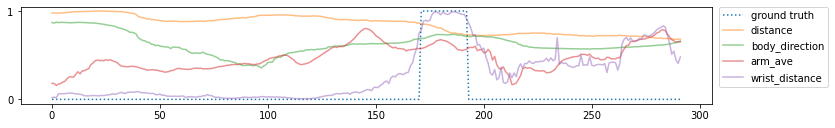

02_20210903_10_131_125


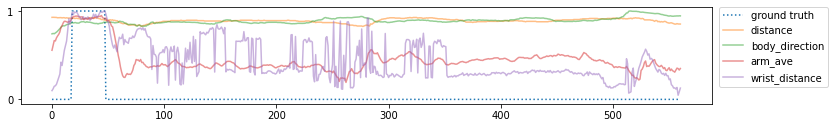

02_20210903_11_142_148


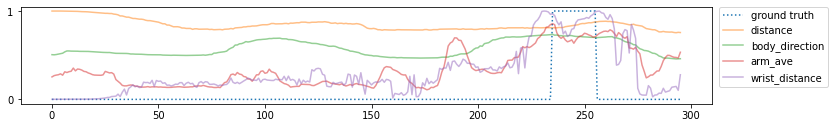

02_20210903_13_177_178


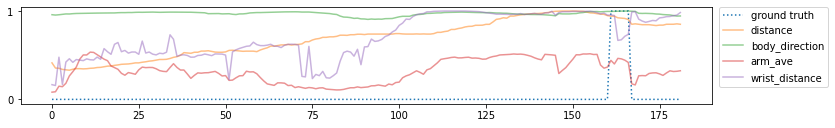

02_20210903_15_205_213


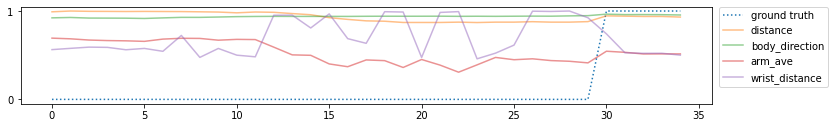

02_20210903_15_213_205


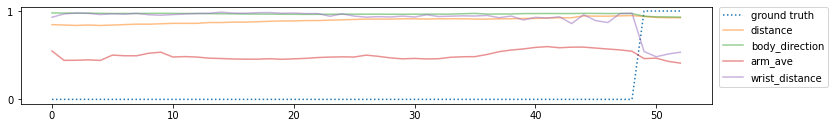

02_20210903_18_265_269


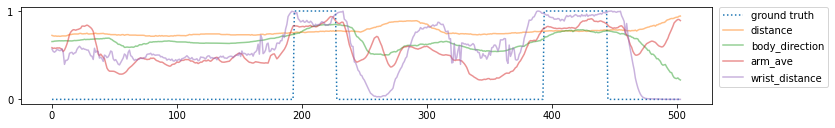

02_20210903_19_277_280


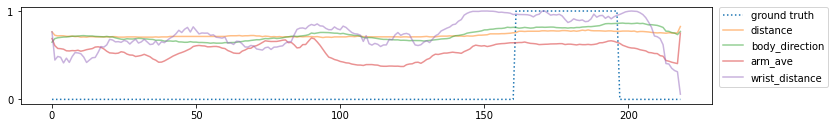

02_20210903_20_286_288


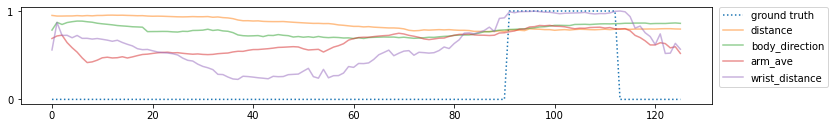

02_20210903_20_286_284


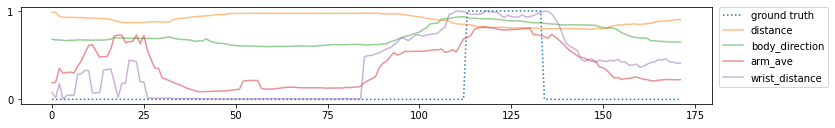

02_20210903_21_308_307


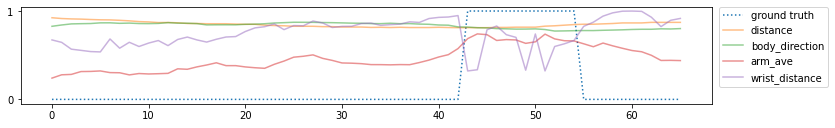

02_20210903_22_309_315


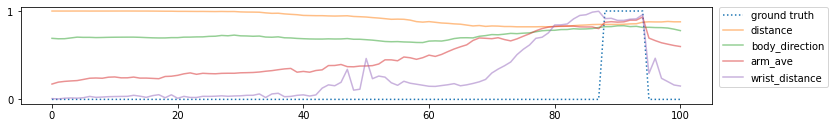

02_20210903_23_324_329


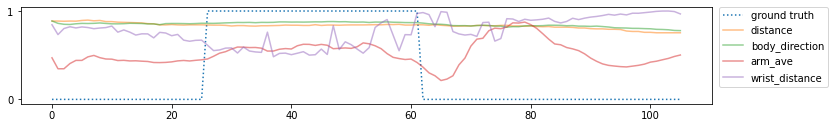

08_20210915_01_3_6


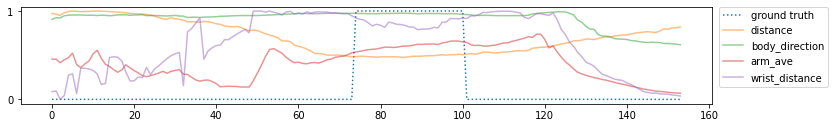

08_20210915_03_26_32


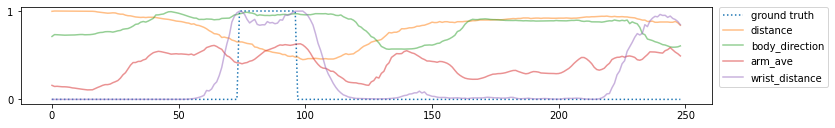

08_20210915_04_40_38


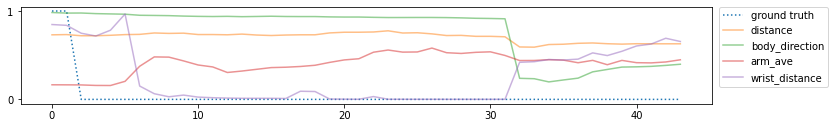

08_20210915_05_49_48


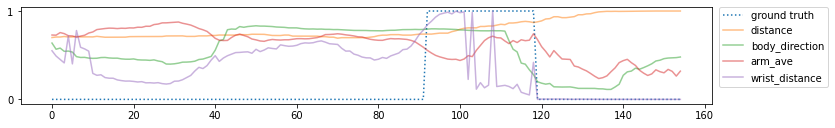

08_20210915_06_56_61


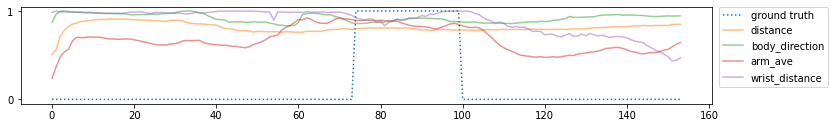

08_20210915_07_67_69


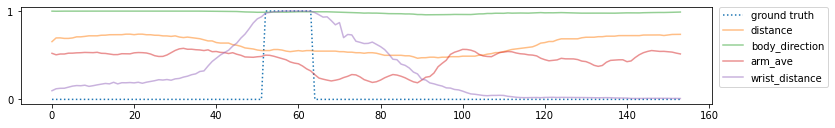

08_20210915_08_73_74


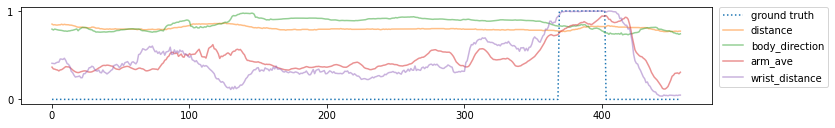

08_20210915_09_90_88


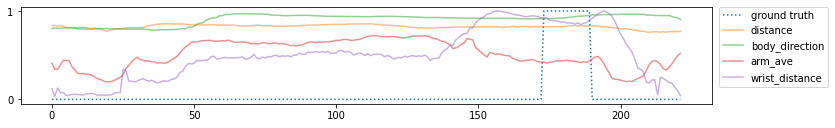

08_20210915_10_98_100


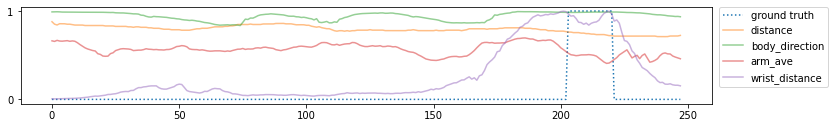

08_20210915_11_112_114


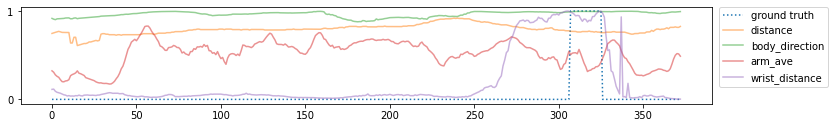

08_20210915_12_134_136


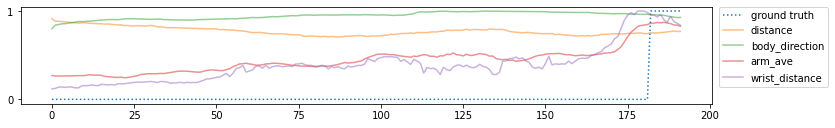

08_20210915_13_143_144


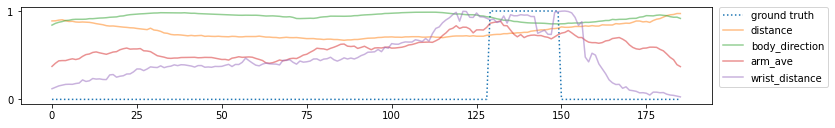

08_20210915_15_165_166


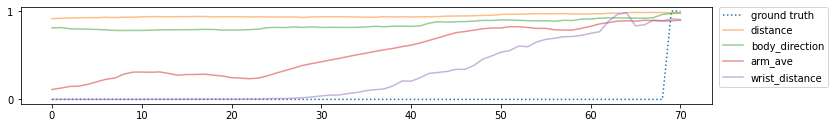

08_20210915_15_166_165


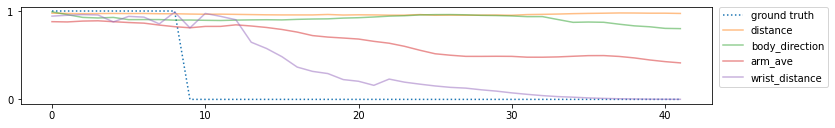

08_20210915_16_175_178


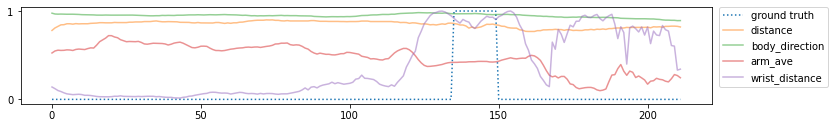

08_20210915_17_185_186


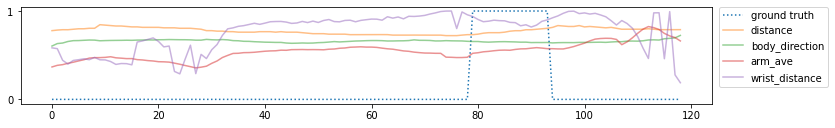

08_20210915_18_193_195


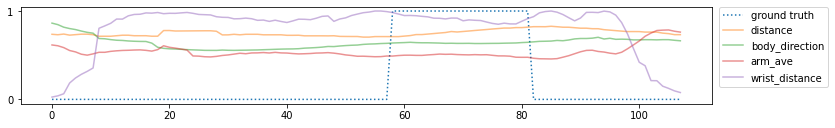

08_20210915_19_202_205


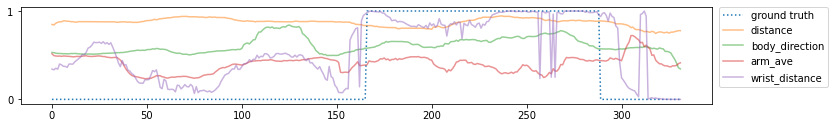

08_20210915_20_215_220


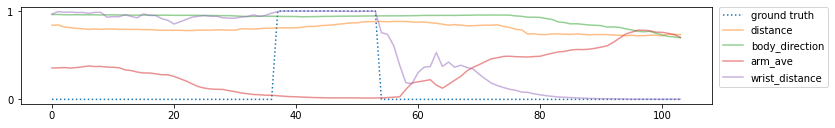

08_20210915_21_227_229


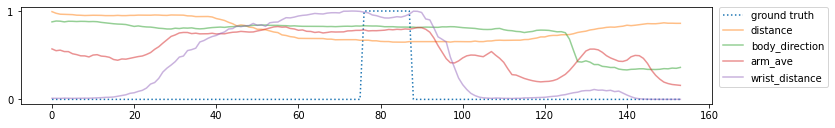

08_20210915_23_244_249


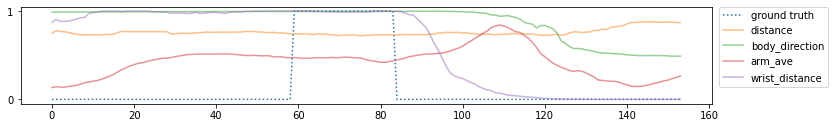

08_20210915_24_254_252


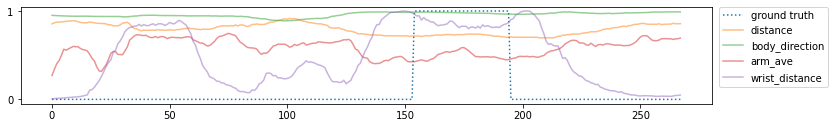

08_20210915_25_270_275


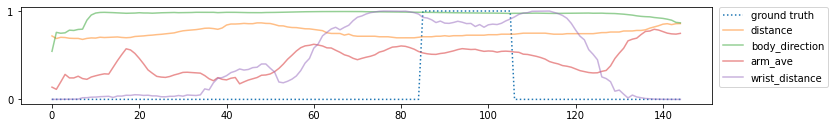

08_20210915_26_282_287


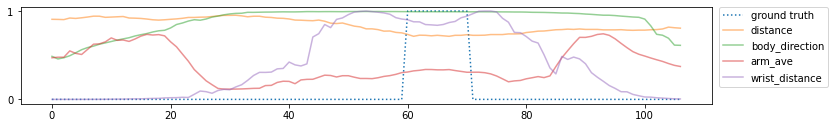

08_20210915_27_300_294


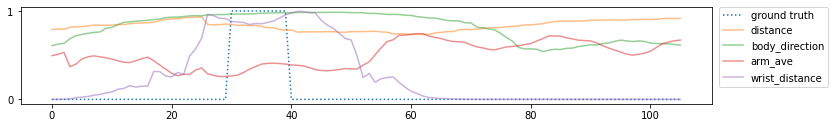

08_20210915_29_317_318


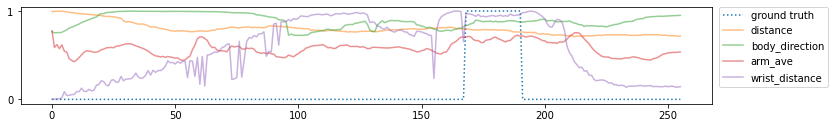

08_20210915_30_324_325


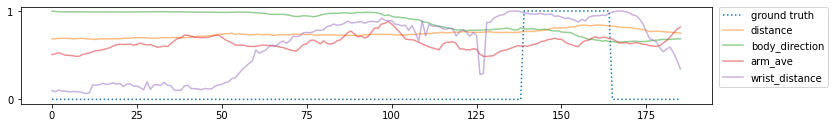

08_20210915_31_336_342


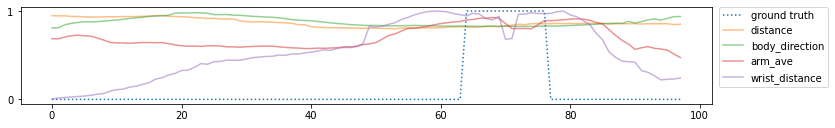

08_20210915_32_346_345


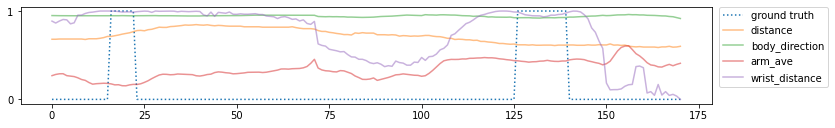

08_20210915_33_355_356


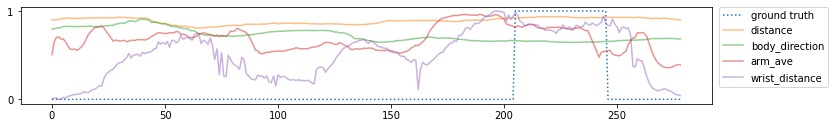

08_20210915_34_364_365


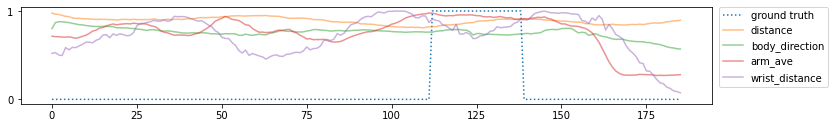

08_20210915_35_373_371


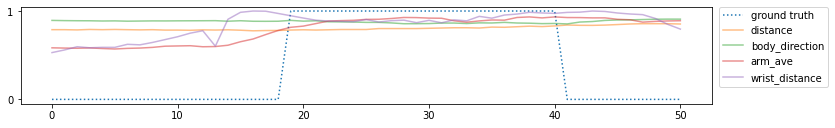

08_20210915_36_383_384


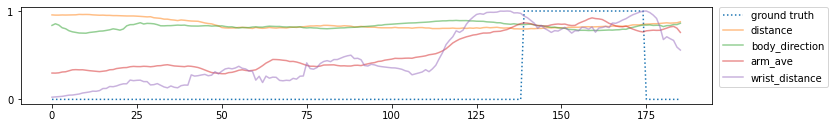

08_20210915_37_392_393


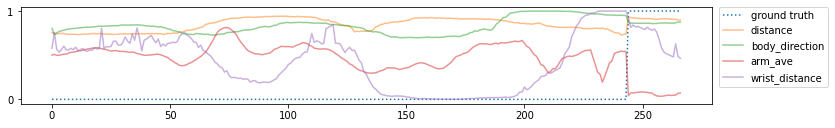

08_20210915_37_393_392


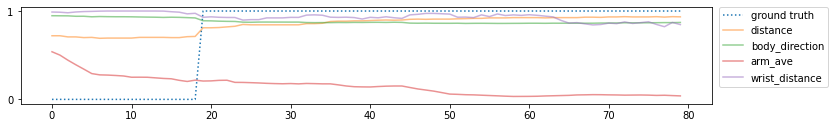

08_20210915_38_402_403


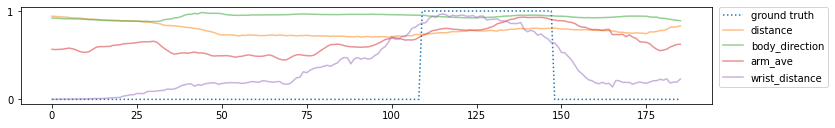

08_20210915_39_411_417


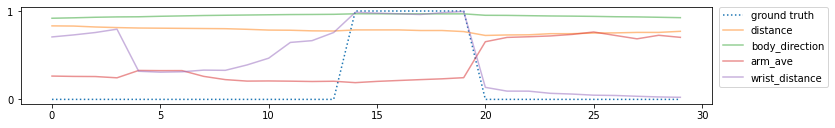

08_20210915_39_417_411


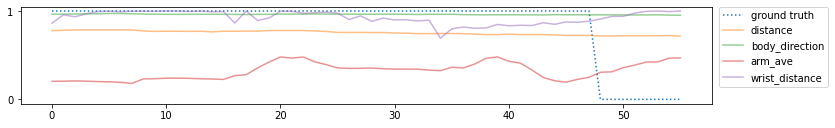

08_20210915_40_424_419


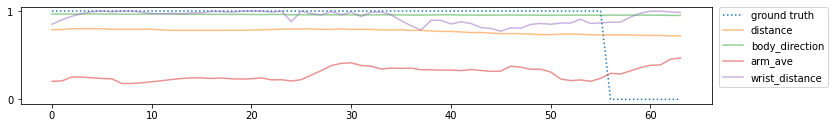

08_20210915_41_428_429


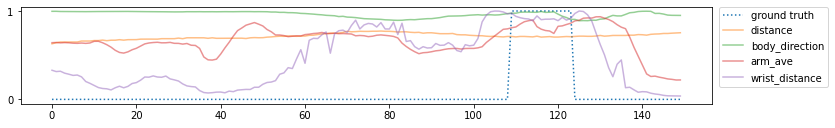

09_20210706_01_1_8


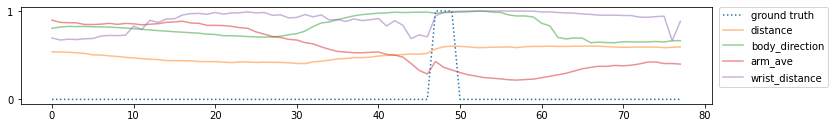

09_20210706_01_8_1


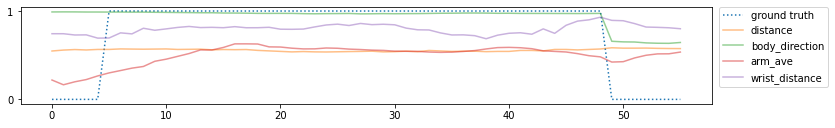

09_20210706_02_20_31


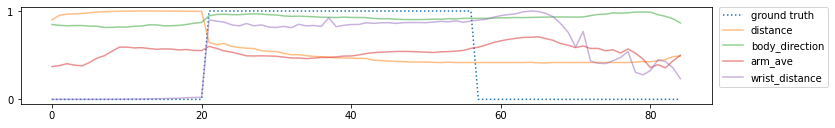

09_20210706_02_31_20


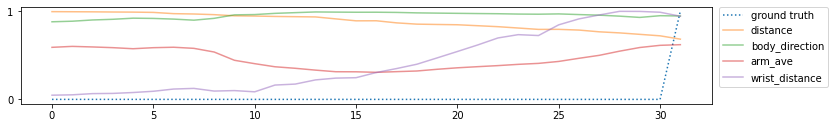

09_20210706_03_42_47


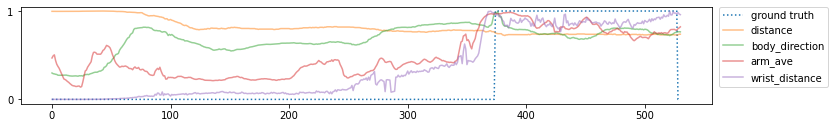

09_20210706_04_63_62


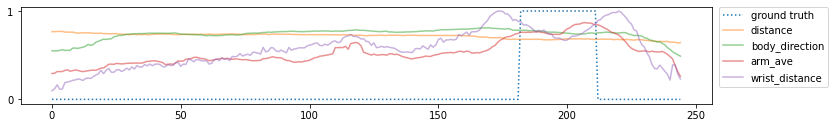

09_20210706_05_81_84


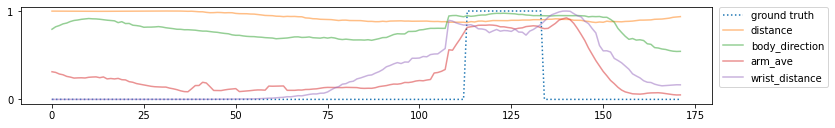

09_20210706_06_86_89


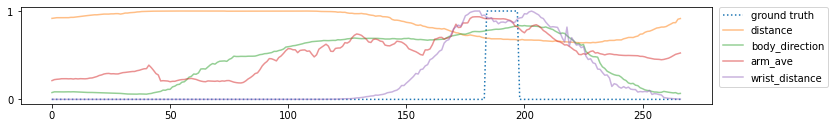

09_20210706_07_96_100


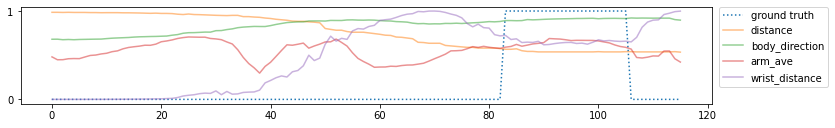

09_20210706_08_106_109


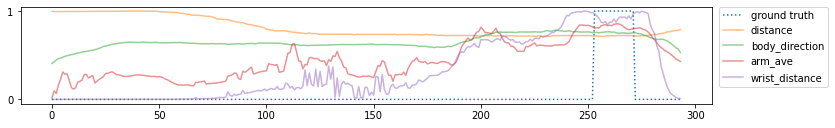

09_20210706_09_118_120


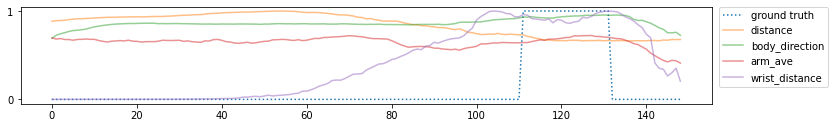

In [26]:
columns = ["distance", "body_direction", "arm_ave", "wrist_distance"]
for key in x_dict.keys():
    x_lst = np.array(x_dict[key])
    y_lst = y_dict[key]

    if 1 not in y_lst:
        continue

    if len(x_lst) < 30:
        continue

    print(key)
    plt.figure(figsize=(10, 1.5))
    # plt.rcParams["font.size"] = 20
    # plt.rcParams["font.family"] = 'Times New Roman'
    plt.plot(y_lst, linestyle=':', label='ground truth')
    for i, x in enumerate(x_lst.T):
        plt.plot(x, alpha=0.5, label=columns[i])
    plt.ylim((-0.05, 1.05))
    plt.yticks([0, 1])
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
    plt.subplots_adjust(left=0.04, right=1, bottom=0.1, top=1)

    plt.show()